In [1]:
!pip install xgboost

In [1]:
import pandas as pd # data manipulation\n",
pd.options.mode.chained_assignment = None  # default='warn'\n",
import numpy as np #  mathematical support for large, multi-dimensional arrays and matrices\n",
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import re
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

import collections
from matplotlib.patches import Arc
import math
#import xgboost
#import dtreeviz
from sklearn.model_selection import KFold


In [2]:

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# allDone()


### Set Directory

In [3]:
try:
    os.chdir('/kaggle/input/football-event-data')
except:
    pass

In [4]:
try:
    os.chdir('/group/interns202010/jmakins/Data')
except:
    pass

In [5]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/Players')
except:
    pass

In [6]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/matches/')
except:
    pass
os.listdir()

['matches_World_Cup.json',
 'matches_Italy.json',
 'matches_Germany.json',
 'matches_England.json',
 'matches_France.json',
 'matches_Spain.json',
 'matches_European_Championship.json']

In [7]:
England = pd.read_json('matches_England.json')
France = pd.read_json('matches_France.json')
Italy = pd.read_json('matches_Italy.json')
Spain = pd.read_json('matches_Spain.json')
Germany = pd.read_json('matches_Germany.json')

England['Country'] = 'England'
France['Country'] = 'France'
Italy['Country'] = 'Italy'
Spain['Country'] = 'Spain'
Germany['Country'] = "Germany"

In [8]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/')
except:
    pass

Teams = pd.read_json('teams.json')
Players = pd.read_json('players.json')

In [9]:
try:
    os.chdir('/Users/Yuval/Desktop/Pawsey/data/events/')
except:
    pass


In [10]:
Events_France = pd.read_json('events_France.json')
Events_Spain = pd.read_json('events_Spain.json')
Events_Germany = pd.read_json('events_Germany.json')
#Events_EuroChamps = pd.read_json('events_European_Championship.json')
#Events_World_Cup = pd.read_json('events_World_Cup.json')
Events_Italy = pd.read_json('events_Italy.json')
Events_England = pd.read_json('events_England.json')

### Data Cleaning

In [11]:
Matches = pd.concat([England, France, Italy, Spain, Germany], ignore_index=True)

In [12]:
Matches.drop(['duration'], inplace=True, axis =1) # removing groupName variable from World Cups

In [13]:
Players.drop(["passportArea"], inplace = True, axis = 1)

In [14]:
Players = Players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [15]:
Teams = Teams.rename(columns = {'wyId': 'teamId'})
Players = Players.rename(columns = {'currentTeamId': 'teamId'})
Players = pd.merge(Players,Teams[['teamId', 'officialName']], on = 'teamId').rename(columns = {'officialName': 'clubName'})

In [16]:
Players['Position'] = Players.role.apply(pd.Series)['code3'].values

In [17]:
Players['birthCountry'] = Players.birthArea.apply(pd.Series)['name'].values

In [18]:
Players.drop(["birthArea", 'role'], inplace = True, axis = 1)

### Manipulate Match Data

In [19]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match

In [20]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for x in teams:
    homeTeam.append(x[0])
    awayTeam.append(x[1])

In [21]:
# add columns for additional match statistics
Matches["homeManagerId"] = None
for name in ["Score", "ScoreHT", "ScoreET", "ScoreP"]:
    colname = "home" + name
    colname2 = "away" + name
    Matches[colname] = None
    Matches[colname2] = None

In [22]:
# parse Home and Away teams as features from nest dictionary
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for game, team in enumerate(teams):
    if Matches.teamsData[game:game+1][game][team[0]]['side'] == 'home':
        homeTeam.append(team[0])
        awayTeam.append(team[1])
    else:
        awayTeam.append(team[0])
        homeTeam.append(team[1])

In [23]:
def get_team_stats(df, team): # function to parse team match stats from dictionary embedded in column teamsData from the Matches dataframe
    
    Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId = [],[],[],[],[],[],[],[]
    
    for game in range(0, len(df)):

        Bench.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['bench'])['playerId']))
        Starters.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['lineup'])['playerId']))
        Manager.append(df.teamsData[game][team[game]]['coachId'])
        Score.append(df.teamsData[game][team[game]]['score'])
        ScoreHT.append(df.teamsData[game][team[game]]['scoreHT'])
        ScoreET.append(df.teamsData[game][team[game]]['scoreET'])
        ScoreP.append(df.teamsData[game][team[game]]['scoreP'])
        teamId.append(df.teamsData[game][team[game]]['teamId'])
    
    return Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId

homeBench, homeStarters, homeManager, homeScore, homeScoreHT, homeScoreET, homeScoreP, homeTeamId = get_team_stats(Matches, homeTeam)
awayBench, awayStarters, awayManager, awayScore, awayScoreHT, awayScoreET, awayScoreP, awayTeamId = get_team_stats(Matches, awayTeam)


In [24]:
# Automating Bench Line Up Column Generation

homeColNames = []
for num in range(1,14): # add columns for home bench playerId
     homeColNames.append("homeBenchPlayer" + str(num))
        
awayColNames = []
for num in range(1,14): # add columns for away bench playerId
    awayColNames.append("awayBenchPlayer" + str(num))
    


In [25]:
# Inspecting bench counts as during errror handling reveals some matches had bench sizes of between 8 and 13 for certain fixtures
import collections
collections.Counter(list(map(lambda x: len(x), homeBench)))

Counter({7: 1425, 6: 18, 5: 1, 8: 5, 12: 205, 10: 49, 11: 101, 9: 21, 13: 1})

In [26]:
# Adding Bench Line Ups to DataFrame

homeBench2 = pd.DataFrame(homeBench,
     columns=homeColNames)
awayBench2 = pd.DataFrame(awayBench,
     columns=awayColNames)


In [27]:
# Automating Starting Line Up Column Generation

homeColNames =[]
for num in range(1,12): # add columns for starting playerId
     homeColNames.append("homePlayer" + str(num))
        
awayColNames = []
for num in range(1,12): # add columns for starting playerId
    awayColNames.append("awayPlayer" + str(num))


In [28]:
# Joining starting line ups, benches to matches dataframe

homeStarters2 = pd.DataFrame(homeStarters,
     columns=homeColNames)
awayStarters2 = pd.DataFrame(awayStarters,
     columns=awayColNames)

Matches = Matches.join([homeStarters2, awayStarters2, homeBench2, awayBench2])


In [29]:
# add individual columns of match data
Matches['homeManager'] = homeManager
Matches['homeScore'] = homeScore
Matches['homeScoreHT'] = homeScoreHT
Matches['homeScoreET'] = homeScoreET
Matches['homeScoreP'] = homeScoreP
Matches['homeTeamId'] = homeTeamId
Matches['awayManager'] = awayManager
Matches['awayScore'] = awayScore
Matches['awayScoreHT'] = awayScoreHT
Matches['awayScoreET'] = awayScoreET
Matches['awayScoreP'] = awayScoreP
Matches['awayTeamId'] = awayTeamId

In [30]:
Matches.drop(["teamsData"], inplace = True, axis = 1)

In [31]:
# Classify Match Result as W, L or D for teams
conditions = [
    (Matches['winner'] == 0),
    (Matches['winner'] == Matches['awayTeamId']),
    (Matches['winner'] == Matches['homeTeamId'])
    ]

# create a list of the values we want to assign for each condition
values = [0, -1, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Matches['Result'] = np.select(conditions, values)

In [32]:
Matches["date"] = pd.to_datetime(Matches['dateutc']).dt.date # create a date column for Matches dataframe

In [33]:
Matches["time"] = pd.to_datetime(Matches['dateutc']).dt.time # create a time column for Matches dataframe

In [34]:
# Prelim Dimensionality Reduction
cols2Drop = ['status', 'roundId', 'gameweek', 'dateutc', 'label', 'referees', 'homeManagerId', 'seasonId']
Matches.drop(cols2Drop, inplace=True, axis =1)
Matches.drop(['winner', 'date', 'time'], inplace = True, axis =1)

In [35]:
Matches.rename(columns={'wyId':'matchId'}, inplace=True)

In [36]:
Matches = Matches.fillna(0) # fill bench7players with Ids = 0 in order to prevent program crashing

### Events Manipulation for Match/Player Stats and then combine with existing Match(test) dataframe from aboves

In [37]:
# Decroos Github
tags = [
    (101, "goal"),
    (102, "own_goal"),
    (301, "assist"),
    (302, "key_pass"),
    (1901, "counter_attack"),
    (401, "left_foot"),
    (402, "right_foot"),
    (403, "head/body"),
    (1101, "direct"),
    (1102, "indirect"),
    (2001, "dangerous_ball_lost"),
    (2101, "blocked"),
    (801, "high"),
    (802, "low"),
    (1401, "interception"),
    (1501, "clearance"),
    (201, "opportunity"),
    (1301, "feint"),
    (1302, "missed_ball"),
    (501, "free_space_right"),
    (502, "free_space_left"),
    (503, "take_on_left"),
    (504, "take_on_right"),
    (1601, "sliding_tackle"),
    (601, "anticipated"),
    (602, "anticipation"),
    (1701, "red_card"),
    (1702, "yellow_card"),
    (1703, "second_yellow_card"),
    (1201, "position_goal_low_center"),
    (1202, "position_goal_low_right"),
    (1203, "position_goal_mid_center"),
    (1204, "position_goal_mid_left"),
    (1205, "position_goal_low_left"),
    (1206, "position_goal_mid_right"),
    (1207, "position_goal_high_center"),
    (1208, "position_goal_high_left"),
    (1209, "position_goal_high_right"),
    (1210, "position_out_low_right"),
    (1211, "position_out_mid_left"),
    (1212, "position_out_low_left"),
    (1213, "position_out_mid_right"),
    (1214, "position_out_high_center"),
    (1215, "position_out_high_left"),
    (1216, "position_out_high_right"),
    (1217, "position_post_low_right"),
    (1218, "position_post_mid_left"),
    (1219, "position_post_low_left"),
    (1220, "position_post_mid_right"),
    (1221, "position_post_high_center"),
    (1222, "position_post_high_left"),
    (1223, "position_post_high_right"),
    (901, "through"),
    (1001, "fairplay"),
    (701, "lost"),
    (702, "neutral"),
    (703, "won"),
    (1801, "accurate"),
    (1802, "not_accurate"),
]

In [38]:
tags = dict(tags)

In [39]:
# ## I have kept this cell encase we need to impute integers for ML algorithms as oppose to strings
# event_tag_ids = []
# for ids in  list(trial[0:10]['tags']):
#     event_tag_ids.append(list(map(lambda y: y['id'], ids)))
# trial['event_tag_ids'] = event_tag_ids

In [40]:
# Store event type tags ids in new column
def event_tags(event_df):
    event_tags = []
    for ids in list(event_df['tags']):
        event_tags.append(list(map(lambda y: tags[y['id']], ids)))

    event_df['event_tags'] = event_tags
    return event_df

In [41]:
def RunningTime(event_df):
    # Solution to convert second half time into 
    secs_to_add = list(event_df[event_df['matchPeriod']=="1H"].groupby('matchId').tail(1)['eventSec'])
    match_ids = list(event_df["matchId"].unique())

    for idx in range(0, len(match_ids)):
        event_df['eventSec'] = list(np.where(
           (event_df['matchId'] == match_ids[idx]) & (event_df['matchPeriod'] == "2H") , event_df['eventSec'] + secs_to_add[idx], event_df['eventSec']
           ))
    return event_df


In [42]:
# Clean the result of the action
def Result(event_df):
    result = []
    for tag in event_df["event_tags"]:
        if "accurate" in tag:
            result.append("Accurate")
        elif "not_accurate" in tag:
            result.append("Inaccurate")
        else:
            result.append("")
    event_df["Result"] = result 
    return event_df

In [43]:
# Separating description from success/failure of an action (event)
def event_description(event_df):
    subEventDescr = []
    for tag in event_df["event_tags"]:
        descr = " ".join(tag[:-1])
        if descr != "":
            subEventDescr.append(descr)
        else:
            subEventDescr.append("generic play")
    event_df["subEventDescription"] = subEventDescr
    event_df = event_df[(event_df["event_tags"].str.len() != 0) & (event_df.subEventName != 'Ball out of the field')  & (event_df.subEventName != 'Goal kick')  ]
    event_df = event_df[event_df["subEventName"] != "Throw in"] # remove throw-ins as a relevant feature among successful teams for simpler analysis, unless its Rory Delap!
    return event_df

In [44]:
# # Separating description from success/failure of an action (event)
# def event_description(event_df):
#     subEventDescr = []
#     for tag in event_df["event_tags"]:
#         descr = " ".join(tag[:-1])
#         if descr != "":
#             subEventDescr.append(descr)
#         else:
#             subEventDescr.append("generic play")
#     event_df["subEventDescription"] = subEventDescr
#     event_df = event_df[(event_df["event_tags"].str.len() != 0) & (event_df.subEventName != 'Ball out of the field')  & (event_df.subEventName != 'Goal kick') & (event_df.subEventName != 'Touch')   ]
#     event_df = event_df[event_df["subEventName"] != "Throw in"] # remove throw-ins as a relevant feature among successful teams for simpler analysis, unless its Rory Delap!
#     return event_df

In [45]:

def Locations(event_df):

    xStart,xEnd,yStart,yEnd = [], [], [], []
    for pos in event_df["positions"]:
        if len(pos) == 2:
            xStart.append(pos[0]['x'])
            xEnd.append(pos[1]['x'])
            yStart.append(pos[0]['y'])
            yEnd.append(pos[1]['y'])
        else:
            xStart.append(pos[0]['x'])
            xEnd.append(pos[0]['x'])
            yStart.append(pos[0]['y'])
            yEnd.append(pos[0]['y'])


    event_df['xStart'], event_df['xEnd'], event_df['yStart'], event_df['yEnd'] = xStart, xEnd, yStart, yEnd
    return event_df

In [46]:
# function to transform an event data frame
def event_df_transform(event_df):
    event_df = event_tags(event_df)
    event_df = Result(event_df)
    event_df = event_description(event_df)
    event_df = Locations(event_df)
    event_df.drop(['positions', "event_tags", "tags", "eventName"], inplace = True, axis = 1) #'id'
    event_df = event_df[event_df.subEventName != ""]
    event_df = event_df[event_df['playerId']!= 0]
    event_df = RunningTime(event_df)
    event_df['attackMetres'] = event_df['xEnd'] - event_df['xStart']
    return event_df

# stopped remove eventId
    

In [53]:
# Transform event_dfs

# Events_France = event_df_transform(Events_France)
# Events_Spain = event_df_transform(Events_Spain)
# Events_Germany = event_df_transform(Events_Germany)
# Events_Italy = event_df_transform(Events_Italy)
# Events_England = event_df_transform(Events_England)


os.chdir('/Users/Yuval/Desktop/Pawsey/data/cleaned_events')

Events_France = pd.read_json('cleaned_events_France.json')
Events_Spain = pd.read_json('cleaned_events_Spain.json')
Events_Germany = pd.read_json('cleaned_events_Germany.json')
Events_Italy = pd.read_json('cleaned_events_Italy.json')
Events_England = pd.read_json('cleaned_events_England.json')

In [54]:
def zones(event_df, start_or_end):

    conditions = [
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 36))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 36)& (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 64)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <=  25))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] >= 0))& (event_df['y'+ start_or_end] <=  25)),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 50))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 25) & (event_df['y'+ start_or_end] <=  36))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 36) & (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 64) & (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 75) & (event_df['y'+ start_or_end] <= 100)))
            ]

    # create a list of the values we want to assign for each condition
    values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

    # create a new column and us np.select to assign values to it using our lists as arguments
    event_df['Zone'+ start_or_end] = np.select(conditions, values)
    
    return event_df



        

In [55]:
for event_df in [Events_England, Events_Italy, Events_Spain, Events_France, Events_Germany]:
    event_df = zones(event_df, "Start")
    event_df = zones(event_df, "End")

In [56]:
### CHange German row with 101
Events_Germany.loc[Events_Germany.yEnd==101, ['yEnd']] = 99

In [57]:
### remove events where playerId equals zero
## There are two instances where goals are scored so we will handle these first and assign to correct players as these are important events
# we can attempt to handle these into the real player sequences if we have time at the end of the project


In [58]:
# function to determine average player coordinates on pitch across all possessions in a match
def playerPosition(event_df):
    df = event_df.groupby(['matchId','playerId']).agg({'xStart': ['mean'], 'yStart': ['mean']}).reset_index()
    df.columns = ["matchId", "playerId", "xStart", "yStart"]
    return df

In [59]:

# find positions for all players for big 5 Euro leagues
a = playerPosition(Events_England)
b = playerPosition(Events_France)
c = playerPosition(Events_Italy)
d = playerPosition(Events_Spain)
e = playerPosition(Events_Germany)

position_df = pd.concat([a,b,c,d,e])


In [60]:

# This dataframe is used relationally to fill correct team as events represent 2018 team, while player
a = Events_England[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
b = Events_France[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
c = Events_Italy[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
d = Events_Spain[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
e = Events_Germany[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
p_refs = pd.concat([a,b,c,d,e])


In [61]:

# Create PA dataframe
Player_Aggs = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]

# add ave field locations to players
Player_Aggs = pd.merge(Player_Aggs, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs = pd.merge(Player_Aggs, p_refs, on = ['matchId', 'playerId'])
Player_Aggs = pd.merge(Player_Aggs, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs = pd.merge(Player_Aggs, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs.loc[Player_Aggs.teamId == Player_Aggs.homeTeamId, 'homeAway'] = "home"
Player_Aggs.loc[Player_Aggs.teamId == Player_Aggs.awayTeamId, 'homeAway'] = "away"


In [62]:
# # # # # #

# var = "Shot"
# varName = "ShotsOnTarget"

# # this exists
# df = Events_England.loc[(Events_England.Result == "Accurate" ) & (Events_England.subEventName== var )].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOnTarget')#.groupby(["matchId",'playerId']).agg(list).reset_index()
# # [['playerId', 'matchId', "ZoneStart"]]
# # # # # # # 

def transform_zonal(df, varName):

    df = df.pivot_table(varName, ['playerId', 'matchId'], 'ZoneStart').fillna(0).reset_index()

    column_indices = []
    new_names = []
    check_cols = list(range(1,27))
    old_columns = list(df.columns[2:])

    for num, col in enumerate(old_columns):
        column_indices.append(num+2)
        new_names.append(varName+ "_ZoneS_" + str(col))

    # columns to be added 
    change_cols = np.setdiff1d(check_cols, old_columns) 

    old_names = df.columns[column_indices]
    df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    for col in change_cols:
        df[varName + "_ZoneS_" + str(col)] = 0

    return df




In [63]:
### unique entry dataframe for player gameTime at any point in a match by summarizing streams

def playerGameTime(event_df):
    df = event_df.groupby(['matchId','playerId'])['eventSec'].agg(['max', 'min']).reset_index()
    df['gameTime (min)'] = round((df['max'] - df['min'])/60) # game time to the nearest minute
    df.drop(['max', 'min'], inplace=True, axis=1)
    return df

# derive gameTime per player and store in summary table
a = playerGameTime(Events_England)
b = playerGameTime(Events_France)
c = playerGameTime(Events_Italy)
d = playerGameTime(Events_Spain)
e = playerGameTime(Events_Germany)

playingTime = pd.concat([a,b,c,d,e]).fillna(0)


In [64]:
def find_goals(event_df):

    # Create a column to recognize when a goal is scored
    conditions = [
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Accurate"))),
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Inaccurate") & (event_df['subEventName'] == "Shot"))),
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Inaccurate") & (event_df['subEventName'] != "Shot")))
        ]

    # create a list of the values we want to assign for each condition
    values = [1, 1, -1]

    # create a new column and use np.select to assign values to it using our lists as arguments
    event_df['Goal_Value'] = np.select(conditions, values, default = 0)
    #[['playerId', 'matchId', "ZoneStart"]].groupby(['playerId', 'matchId', "ZoneStart"])
    return event_df.groupby(['playerId', 'matchId', "ZoneStart"]).sum().reset_index()#[['playerId', 'matchId', 'Goal_Value']]

In [65]:
for event in [Events_England, Events_Italy, Events_France, Events_Germany, Events_Spain]:
    event = find_goals(event)


In [66]:
Player_Aggs = pd.merge(Player_Aggs, playingTime, how = 'left', on = ['playerId', 'matchId'])

In [67]:
# convenience function for event_df parsing
def parseEvent_df(func, new_feature):
    
    aa = func(Events_England)
    aa = transform_zonal(aa, new_feature)
#     aa = aa.rename_axis(None, axis=1)
    bb = func(Events_France)
    bb = transform_zonal(bb, new_feature)
#     bb = bb.rename_axis(None, axis=1)
    cc = func(Events_Italy)
    cc = transform_zonal(cc, new_feature)
#     cc = cc.rename_axis(None, axis=1)
    dd = func(Events_Spain)
    dd = transform_zonal(dd, new_feature)
#     dd = dd.rename_axis(None, axis=1)
    ee = func(Events_Germany)
    ee = transform_zonal(ee, new_feature)
#     ee = ee.rename_axis(None, axis=1)
    
    return pd.concat([aa,bb,cc,dd,ee])

In [68]:
# function for adding new feature column to Player_Aggs df
def alter_Player_Aggs(new_feature_function, new_feature, PA_df):
    
    if "Acc" in new_feature:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
    elif 'acc' in new_feature:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
    else:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
#         PA_df[new_cols] = (PA_df[new_cols] / PA_df['gameTime (min)']) * 90 # get standardized stat index for 90mins
    PA_df.iloc[:,15:] = PA_df.iloc[:,15:].fillna(0)
    return PA_df


In [69]:
# import datetime
# while datetime.datetime.now().hour < 17:
#     x = 1+1

In [70]:
# calc angle to goal from any location in radians

def angleToGoal(event_df):
    
    event_df['C'] = 10 # length of goal
    event_df['A'] = ((100-event_df.xStart)**2+abs(45-event_df.yStart)**2)**.5
    event_df['B'] = ((100-event_df.xStart)**2+abs(55-event_df.yStart)**2)**.5
    event_df['angle_to_goal'] = (event_df['A'] * event_df['A'] + event_df['B'] * event_df['B'] - event_df['C'] * event_df['C'])/(2 * event_df['A'] * event_df['B'])
    event_df['angle_to_goal'] = event_df['angle_to_goal'].apply(lambda row: round(math.radians(math.degrees(math.acos(row))),4))
    # event_df['angle_to_goal'] = event_df['angle_to_goal'].apply(lambda row: round(math.degrees(row),2))
    event_df.drop(['A', "B", "C"], inplace = True, axis=1)
    return event_df
        
Events_England, Events_France = angleToGoal(Events_England), angleToGoal(Events_France)
Events_Germany, Events_Spain = angleToGoal(Events_Germany), angleToGoal(Events_Spain)
Events_Italy = angleToGoal(Events_Italy)


### Function to prepare dataframe for fdnn

In [71]:
# result is event_df

def player_goals(result):
    
    conditions = [
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Accurate"))),
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Inaccurate") & (result['subEventName'] == "Shot"))),
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Inaccurate") & (result['subEventName'] != "Shot")))
            ]

    # create a list of the values we want to assign for each condition
    values = [1, 1, -1]

    # create a new column and us np.select to assign values to it using our lists as arguments
    result['Goal_Value'] = np.select(conditions, values, default = 0)
    
    return result

    

In [72]:
def corner_assists(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerAssists')

def corner_opportunity(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('key_pass'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerOpportunitiesCreated')

def corner_success(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulCorners')

def corner_fail(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FailedCorners')

def corner_assists(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerAssists')


In [73]:
### Attack Metres stat (how many forward metres achieved through events)
def AccBackwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Accurate" ) & (event_df.attackMetres < 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccBackMetres"})
    df["AccBackMetres"] = df["AccBackMetres"].abs()
    return df

def InaccBackwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Inaccurate") & (event_df.attackMetres < 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccBackMetres"})
    df["InaccBackMetres"] = df["InaccBackMetres"].abs()
    return df


### Attack Metres stat (how many forward metres achieved through events)
def AccForwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.attackMetres > 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccForwardMetres"})
    return df

def InaccForwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Inaccurate") & (event_df.attackMetres > 0 ) ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccForwardMetres"})
    return df


In [74]:

# adding in total meterage of accurate and inaccurate movements by players in the vertical plane towards the goal
# AccBackward = parseEvent_df(AccBackwardMetres)
# InaccBackward = parseEvent_df(InaccBackwardMetres)
# AccForward = parseEvent_df(AccForwardMetres)
# InaccForward= parseEvent_df(InaccForwardMetres)

# Player_Aggs = pd.merge(Player_Aggs, AccBackward, how= 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, InaccBackward, how = 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, AccForward, how= 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, InaccForward, how = 'left', on =['playerId', 'matchId'])
# Player_Aggs.AccForwardMetres = Player_Aggs.AccForwardMetres.fillna(0)
# Player_Aggs.InaccForwardMetres = Player_Aggs.InaccForwardMetres.fillna(0)-
# Player_Aggs.AccBackMetres = Player_Aggs.AccBackMetres.fillna(0)
# Player_Aggs.InaccBackMetres = Player_Aggs.InaccBackMetres.fillna(0)


##### Explore Feature

In [75]:
Events_England.subEventName.unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Cross', 'Shot',
       'Reflexes', 'Touch', 'Clearance', 'Free Kick', 'Corner',
       'Hand pass', 'Acceleration', 'Save attempt', 'Free kick cross',
       'Foul', 'Free kick shot', 'Hand foul', 'Violent Foul', 'Protest',
       'Goalkeeper leaving line', 'Late card foul', 'Out of game foul',
       'Penalty', 'Time lost foul', 'Simulation'], dtype=object)

#### Miscellanous 

In [76]:
def SimulationFouls(event_df):
    df = event_df[(event_df.subEventName=="Simulation")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SimulationFouls')
    return df

def Fouls(event_df):
    df= event_df[(event_df.subEventName.str.contains('foul'))| (event_df.subEventName.str.contains('Foul'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FoulsCommited')

    return df

def Clearances(event_df):
    df =  event_df[(event_df.subEventName=="Clearance")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Clearances')

    return df
    
def AccLaunchMetres(event_df):
    df =  event_df.loc[(event_df.Result == "Accurate") &(event_df.subEventName=="Launch")].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccLaunchMetres"})

    return df
    
def InaccLaunchMetres(event_df):
    df = event_df.loc[(event_df.Result == "Inaccurate") &(event_df.subEventName=="Launch")].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccLaunchMetres"})

    return df

def FreeKickCrossKey(event_df):
    df = event_df[(event_df.subEventName == "Free kick cross")&(event_df.subEventDescription.str.contains("key"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FKKeyCross')

    return df
        
def FreeKickCrossAssists(event_df):
    df = event_df[(event_df.subEventName == "Free kick cross")&(event_df.subEventDescription.str.contains("assist"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FKCrossAssists')
    return df
    
def FreeKickCrossAccuracy(event_df):
    df1= event_df[(event_df.subEventName == "Free kick cross")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickCrosses')
    df2 = event_df[(event_df.subEventName == "Free kick cross")& (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccFreeKickCrosses')

    return df2


In [77]:
#penaltiesConversion Statistic

def PenaltiesConverted(event_df):
    df1= event_df[(event_df.subEventName == "Penalty")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltiesAttempted')

    df2 = event_df[(event_df.subEventName == "Penalty")& (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltiesScored')

    df1 = pd.merge(df1,df2, how='left', on = ['matchId', 'playerId'])
    df1['PenaltiesScored'] = df1['PenaltiesScored'].fillna(0)
    df1['penaltiesConversion'] = df1['PenaltiesScored'] / df1['PenaltiesAttempted']
    df1.drop(['PenaltiesScored', 'PenaltiesAttempted' ], inplace=True, axis =1)


    return df1


In [78]:
# 'Ground loose ball duel', 'Ground defending duel'
def dangerousOpponentHalfRecoveries(event_df):
    df = event_df[((event_df.subEventDescription.str.contains("won")) | (event_df.subEventDescription.str.contains("interception") & (event_df.Result=="Accurate"))) & (event_df.subEventName!="Ground attacking duel") & (event_df.xEnd > 60)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousOpponentHalfRecoveries')
    return df
    
def dangerousOwnHalfBallLost(event_df):
    df = event_df[(event_df.Result=="Inaccurate") & (event_df.xEnd<40) & ((event_df.subEventName.str.contains("pass")) | (event_df.subEventName.str.contains("Acceleration")) | (event_df.subEventName.str.contains("Clearance")) | ((event_df.subEventName.str.contains("duel")) &(event_df.subEventName!='Ground defending duel')) | (event_df.subEventName.str.contains("Launch")))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousOwnHalfBallLost')
    return df
    
    
def dangerousDefDuelsLost(event_df):
    df = event_df[(event_df.Result=="Inaccurate") & (event_df.xEnd<40) & (event_df.subEventName=="Ground defending duel")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousDefDuelsLost')
    return df


In [79]:
### Step one proportion of low left shots saved

possies = ['low_left', 'mid_left', 'high_left', 'low_center', 'mid_center', 'high_center', 'low_right', 'mid_right', 'high_right']

def GoalKeepingZoneEfficiency(event_df, pos):
    df1= event_df[((event_df.subEventName=="Save attempt") | (event_df.subEventName=="Reflexes")) &(event_df.subEventDescription.str.contains(pos))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='total_'+pos)

    df2 = event_df[((event_df.subEventName=="Save attempt") | (event_df.subEventName=="Reflexes")) &(event_df.subEventDescription.str.contains(pos)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name=pos+'_saves')

    df1 = pd.merge(df1,df2, how='left', on = ['matchId', 'playerId'])
    df1[pos+'_saves'] = df1[pos+'_saves'].fillna(0)
    df1[pos+'_save_efficiency'] = df1[pos+'_saves'] / df1['total_'+pos]
    df1.drop([pos+'_saves', 'total_'+pos], inplace=True, axis =1)
#     df1 = transform_zonal(df1, desiredName)
    return df1


# for pos in possies:
#     a = GoalKeepingZoneEfficiency(Events_England, pos)
#     b = GoalKeepingZoneEfficiency(Events_France, pos)
#     c = GoalKeepingZoneEfficiency(Events_Italy, pos)
#     d = GoalKeepingZoneEfficiency(Events_Spain, pos)
#     e = GoalKeepingZoneEfficiency(Events_Germany, pos)
#     df = pd.concat([a,b,c,d,e])
#     Player_Aggs = pd.merge(Player_Aggs, df, how= 'left', on = ['playerId', 'matchId'])
#     Player_Aggs[ pos + '_save_efficiency'] = Player_Aggs[pos + '_save_efficiency'].fillna(0)
    

In [80]:
# Goals allowed
def goalsAllowed(event_df):
    df = event_df[((event_df.subEventName == "Reflexes")|(Events_England.subEventName == "Save attempt")) & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='goalsAllowed')
#     df = transform_zonal(df, desiredName)
    return df

# Successful save attempt
def Saves(event_df):
    df= event_df[((event_df.subEventName == "Save attempt")|(Events_England.subEventName == "Save attempt"))&(event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GkSaves')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Hand Pass
def SuccessHandPass(event_df):
    df= event_df[(event_df.subEventName == "Hand pass")&(event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateHandPass')
#     df = transform_zonal(df, desiredName)
    return df
# Inaccurate Hand Pass
def FailedHandPass(event_df):
    df = event_df[(event_df.subEventName == "Hand pass")&(event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateHandPass')
#     df = transform_zonal(df, desiredName)
    return df

# GoalKeeper Leaving Line 
def LeavingLine(event_df):
    df = event_df[(event_df.subEventName=="Goalkeeper leaving line")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GKLeavingLineInstance')
#     df = transform_zonal(df, desiredName)
    return df


#### Crosses, Dribbles, Accelerations

In [81]:
# Number of succesful accelerations
def SuccessAccelerations(event_df):
    df = event_df[(event_df.subEventName == 'Acceleration') & (event_df.Result == 'Accurate')].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulAccels')
#     df = transform_zonal(df, desiredName)
    return df

# Number of failed accelerations
def FailedAccelerations(event_df):
    df = event_df[(event_df.subEventName == 'Acceleration') & (event_df.Result == 'Inaccurate')].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FailedAccels')
#     df = transform_zonal(df, desiredName)
    return df

# Total acceleration metres
def AccelDistance(event_df):
    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "CumAccelerationDist"})
#     df = transform_zonal(df, desiredName)
    return df

# Accelerations into final third
def AccelsIntoFinalThird(event_df):
    df= event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") & (event_df.xStart <= 66)  & (event_df.xEnd > 66)].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccelsDistIntoFinal3rd"})
#     df = transform_zonal(df, desiredName)
    return df

# Acceleration within final third
def AccelsWithinFinalThird(event_df):
    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") & (event_df.xStart > 66) ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccelsDistWithinFinal3rd"})
#     df = transform_zonal(df, desiredName)
    return df


##### Crossing

In [82]:
# cross assists
def crossAssists(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CrossAssists')
    df = transform_zonal(df, desiredName)
    return df

# right foot crosses
def RightFootCross(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('right_foot'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='RightFootCross')
#     df = transform_zonal(df, desiredName)
    return df

# left foot crosses
def LeftFootCross(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('left_foot'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='LeftFootCross')
#     df = transform_zonal(df, desiredName)
    return df

# cross key passes
def CrossKeyPasses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('key_pass'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CrossKeyPass')
#     df = transform_zonal(df, desiredName)
    return df

# accurate crosses
def AccurateCrosses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccCrosses')
#     df = transform_zonal(df, desiredName)
    return df

# inaccurate crosses
def InaccurateCrosses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccCrosses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate crosses into penalty box
def AccCrossesBox(event_df):
    df = event_df[(event_df.subEventName == 'Cross') 
               & (event_df.Result=="Accurate") 
               & (event_df.xEnd > 82)
               & (event_df.yEnd < 80)
               & (event_df.yEnd > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccCrossesIntoBox')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate crosses into penalty box
def InaccCrossesBox(event_df):
    df = event_df[(event_df.subEventName == 'Cross') 
               & (event_df.Result=="Inaccurate") 
               & (event_df.xEnd > 82)
               & (event_df.yEnd < 80)
               & (event_df.yEnd > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccCrossesIntoBox')
#     df = transform_zonal(df, desiredName)
    return df



#### Tackles & Ground Duels

In [83]:
# Sliding tackles won
def slidingTacklesWon(event_df):
    df = event_df[(event_df.subEventDescription.str.contains("sliding_tackle won"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SlidingTacklesWon')
#     df = transform_zonal(df, desiredName)
    return df

# Sliding tackles lost
def slidingTacklesLost(event_df):
    df = event_df[(event_df.subEventDescription.str.contains("sliding_tackle lost"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SlidingTacklesLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defending Duels Won
def GroundDuelsWon(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("won")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundDefDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defending Duels Lost
def GroundDuelsLost(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("lost")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundDefDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defensive Anticipations
def GroundDefAnticipations(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("anticipated")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='DefensiveAnticipations')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Loose Balls Won
def GroundLooseBallsWon(event_df):
    df = event_df[(event_df.subEventName == 'Ground loose ball duel') &(event_df.subEventDescription.str.contains('won'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundLooseBallsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Loose Balls Lost
def GroundLooseBallsLost(event_df):
    df = event_df[(event_df.subEventName == 'Ground loose ball duel') &(event_df.subEventDescription.str.contains('lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundLooseBallsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground attacking duels won
def GroundAttackDuelsWon(event_df):
    df = event_df[(event_df.subEventName == 'Ground attacking duel') &(event_df.subEventDescription.str.contains('won'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundAttackDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground attacking duels lost
def GroundAttackDuelsLost(event_df):
    df = event_df[(event_df.subEventName == 'Ground attacking duel') &(event_df.subEventDescription.str.contains('lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundAttackDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Offensive Touches in box
def OffTouchesBox(event_df):
    df = event_df[(event_df.subEventName == 'Touch')
              & (event_df.xStart > 82)
              & (event_df.yStart < 80)
              & (event_df.yStart > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='OffensiveTouchesBox')
#     df = transform_zonal(df, desiredName)
    return df


#### Shots & Goals

In [84]:
# Shots on Target
def ShotsOnTarget(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOnTarget')
#     df = transform_zonal(df, desiredName)
    return df

# Shots off Target
def ShotsOffTarget(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOffTarget')
#     df = transform_zonal(df, desiredName)
    return df

# Shot opportunity
def shot_opportunities(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.contains("opportunity"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotOpportunities')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate free kick shots
def accFreeKicks(event_df):
    df = event_df[(event_df.subEventName=="Free kick shot") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickShotAcc')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate free kick shots
def InaccFreeKicks(event_df):
    df = event_df[(event_df.subEventName=="Free kick shot") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickShotInacc')
#     df = transform_zonal(df, desiredName)
    return df

# Did not score penalty
def PenaltyNotGoal(event_df):
    df = event_df[(event_df.subEventName=="Penalty") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltyNotScored')
#     df = transform_zonal(df, desiredName)
    return df

# Goal scored with head/body
def HeaderGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("head"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Header/Body_Goal')
#     df = transform_zonal(df, desiredName)
    return df    
    
# Goal scored with right foot
def RightFootGoal(event_df): 
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("right_foot"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='RightFootGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Goal scored with left foot
def LeftFootGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("left_foot"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='LeftFootGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Counter Attack Goal
def CounterAttackGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("counter_attack"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Interception Goal
def InterceptionGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
                & (event_df.subEventDescription.str.contains("interception"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InterceptionGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Goal positions
def GoalPositions(event_df, pos):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
                  & (event_df.subEventDescription.str.contains(pos))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Goal_'+pos)
#     df = transform_zonal(df, desiredName)
    return df

def OwnGoals(event_df):
    df = event_df[event_df.subEventDescription.str.contains("own")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='OwnGoals')
#     df = transform_zonal(df, desiredName)
    return df

def shotAccuracy(event_df):
    df1 = event_df[(event_df.subEventName.str.contains('Shot')) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('Shot')) ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shotAccuracy'] = df1['ShotAccuracy1'] / df1['ShotAccuracy2']
    df1.drop(['ShotAccuracy1', 'ShotAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1




In [85]:
# # Get positional zones of goals for players

# possies = ['low_left', 'mid_left', 'high_left', 'low_center', 'mid_center', 'high_center', 'low_right', 'mid_right', 'high_right']
# for pos in possies:
#     a = GoalPositions(Events_England, pos)
#     b = GoalPositions(Events_France, pos)
#     c = GoalPositions(Events_Italy, pos)
#     d = GoalPositions(Events_Spain, pos)
#     e = GoalPositions(Events_Germany, pos)
#     df = pd.concat([a,b,c,d,e])
#     Player_Aggs = pd.merge(Player_Aggs, df, how= 'left', on =['playerId', 'matchId'])
#     Player_Aggs["Goal_"+pos] = Player_Aggs["Goal_"+pos].fillna(0)

# Player_Aggs = Player_Aggs.drop_duplicates()


####   Air duel

In [86]:
def AerialDuelsWon(events_df):
    df = Events_England[(Events_England.subEventName=="Air duel") & (Events_England.subEventDescription.str.contains("won"))].groupby(['playerId', 'matchId', 'ZoneStart']).size().reset_index(name='AerialDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

def AerialDuelsLost(events_df):
    df =  Events_England[(Events_England.subEventName=="Air duel") & (Events_England.subEventDescription.str.contains("lost"))].groupby(['playerId', 'matchId', 'ZoneStart']).size().reset_index(name='AerialDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df


#### Passing

In [87]:
# Accurate forward passes
def acc_forward_pass(event_df):
    df = event_df[(event_df.subEventName=="Simple pass") 
                   & (event_df.attackMetres>0)
                   & (event_df.Result=="Accurate")
                   & (event_df.subEventDescription.str.match('generic play'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateForwardPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate forward passes 
def inacc_forward_passes(event_df):
    df = event_df[(event_df.subEventName=="Simple pass") 
                   & (event_df.attackMetres>0)
                   & (event_df.Result=="Inaccurate")
                   & (event_df.subEventDescription.str.match('generic play'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateForwardPasses')
#     df = transform_zonal(df, desiredName)
    return df

# SuccessfulInterceptions ## when a player intercepts a play and makes a successful subsequent play
def success_intercept(event_df):
    df = event_df[(event_df.Result == 'Accurate')
                   & (event_df.subEventDescription.str.match('interception'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulInterceptions')
#     df = transform_zonal(df, desiredName)
    return df

# CounterAttackInterceptions
def CounterAttackIntercepts(event_df):
    df = event_df[(event_df.subEventDescription.str.match('counter_attack interception'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackIntercept')
#     df = transform_zonal(df, desiredName)
    return df

# DangerousBallLostPassing
def dangerous_ball_lost(event_df):
    df = event_df[(event_df.subEventName.str.contains("pass")) 
                   & (event_df.subEventDescription.str.match('dangerous_ball_lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassLostDangerous')
#     df = transform_zonal(df, desiredName)
    return df

# Counter attack involvements
def CounterAttackInvolvements(event_df):
    df = event_df[(event_df.subEventDescription.str.match('counter_attack')) 
                  & (event_df.Result == 'Accurate') ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackInvolvements')
#     df = transform_zonal(df, desiredName)
    return df

# Total Assists
def total_assists(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('assist')) 
                  & (event_df.Result == 'Accurate') ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='TotalAssists')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Keypasses
def inacc_key_passes(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('key_pass')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateKeyPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Keypasses
def acc_keypasses(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('key_pass')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateKeyPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Through Passes
def acc_throughs(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateThroughPasses')
#     df = transform_zonal(df, desiredName)
    return df
# Inaccurate Through Passes
def inacc_throughs(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateThroughPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Smart Passes 
def acc_smart_passes(event_df):
    df = event_df[(event_df.subEventName.str.match('Smart pass')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateSmartPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Smart Passes 
def inacc_smartPasses(event_df):
    df = event_df[(event_df.subEventName.str.match('Smart pass')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateSmartPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Through passes into final third
def throughs_into_final(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66 ) 
                 & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccThroughsIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes into final third
def accPasses_into_final(event_df):
    df = event_df[ ( event_df.subEventName.str.contains('pass'))
        & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Accurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccPassesIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes into final third
def InaccPasses_into_final(event_df):
    df = event_df[ ( event_df.subEventName.str.contains('pass'))
        & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Inaccurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccPassesIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes within final third
def accPasses_within_finalThird(event_df):
    df = event_df[ (event_df.subEventName.str.contains("pass") )
                   & (event_df.xStart > 66 ) 
                  & (event_df.xEnd > 66 ) 
                 & (event_df.Result == "Accurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccPassesWithinFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Passes within final third   
def inaccPasses_within_finalThird(event_df):
    df = event_df[ (event_df.subEventName.str.contains("pass") )
                   & (event_df.xStart > 66 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Inaccurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccPassesWithinFinalThird')
#     df = transform_zonal(df, desiredName)
    return df


In [88]:
def shortLongPassRatio(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & ((event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass')) & (((event_df.attackMetres)>20) | (abs(event_df.lateralMetres>20))) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shortLongPassRatio'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1

def longPassAccuracy(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & ((abs(event_df.attackMetres)>20) | abs(event_df.lateralMetres>20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass')) & ((abs(event_df.attackMetres)>20) | abs(event_df.lateralMetres>20)) ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['longPassAccuracy'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1

def shortPassAccuracy(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & (abs(event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass'))& (abs(event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20))  ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shortPassAccuracy'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
    return df1

In [89]:
Events_England["ReceivingPlayer"] = Events_England['playerId'].shift(-1)

#### Live match analysis

In [90]:
liveTimes = []
for time in range(600, 6000, 600):
    liveTimes.append(time)

In [91]:
#### path = os.getcwd()
# Events_England.to_csv(path+'/Events_England_processed')
# Events_France.to_csv(path+'/Events_France_processed')
# Events_Italy.to_csv(path+'/Events_Italy_processed')
# Events_Spain.to_csv(path+'/Events_Spain_processed')
# Events_Germany.to_csv(path+'/Events_Germany_processed')


In [92]:

# Events_England_live = Events_England[Events_England.eventSec <= liveTime]
# Events_France_live = Events_France[Events_France.eventSec <= liveTime]
# Events_Italy_live = Events_Italy[Events_Italy.eventSec <= liveTime]
# Events_Spain_live = Events_Spain[Events_Spain.eventSec <= liveTime]
# Events_Germany_live = Events_Germany[Events_Germany.eventSec <= liveTime]


In [93]:

Player_Aggs_live = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]
Player_Aggs_live = pd.merge(Player_Aggs_live, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs_live = pd.merge(Player_Aggs_live, p_refs, on = ['matchId', 'playerId'])
Player_Aggs_live = pd.merge(Player_Aggs_live, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs_live = pd.merge(Player_Aggs_live, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.homeTeamId, 'homeAway'] = "home"
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.awayTeamId, 'homeAway'] = "away"


In [94]:
def playerGameTime_live(event_df, time):
    df = event_df.groupby(['matchId','playerId'])['eventSec'].agg([ 'min']).reset_index()
    df['liveTime'] = time
    df['gameTime (min)'] = round((df['liveTime'] - df['min'])/60) # game time to the nearest minute
    # Classify Match Result as W, L or D for teams
    conditions = [
        (df['gameTime (min)']  < 1),
        (df['gameTime (min)'] > 0)
        ]

    # create a list of the values we want to assign for each condition
    values = [0, df['gameTime (min)'].max()]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['gameTime (min)'] = np.select(conditions, values)
    
    df.drop(['liveTime', 'min'], inplace=True, axis=1)
    return df



In [95]:
# convenience function for event_df parsing
def parseEvent_df_live(func, new_feature, time, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live):
    
    aa = func(df_England_live)
    aa = transform_zonal(aa, new_feature)
    bb = func(df_France_live)
    bb = transform_zonal(bb, new_feature)
    cc = func(df_Italy_live)
    cc = transform_zonal(cc, new_feature)
    dd = func(df_Spain_live)
    dd = transform_zonal(dd, new_feature)
    ee = func(df_Germany_live)
    ee = transform_zonal(ee, new_feature)
    
    
    try:
        return pd.concat([aa,bb,cc,dd,ee])
    except:
        return None


In [96]:
# function for adding new feature column to Player_Aggs df

def alter_Player_Aggs_live(new_feature_function, new_feature, PA_df, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live):

    df = parseEvent_df_live(new_feature_function, new_feature, time, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live)

    try:
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
    
    except:
        return PA_df
    
    return PA_df


In [97]:
Player_Aggs_live = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]
Player_Aggs_live = pd.merge(Player_Aggs_live, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs_live = pd.merge(Player_Aggs_live, p_refs, on = ['matchId', 'playerId'])
Player_Aggs_live = pd.merge(Player_Aggs_live, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs_live = pd.merge(Player_Aggs_live, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.homeTeamId, 'homeAway'] = "home"
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.awayTeamId, 'homeAway'] = "away"

In [98]:
# funkies = [AccBackwardMetres, InaccBackwardMetres, AccForwardMetres, InaccForwardMetres, SimulationFouls, Fouls, Clearances, AccLaunchMetres, InaccLaunchMetres, FreeKickCrossKey, FreeKickCrossAccuracy, dangerousOpponentHalfRecoveries, dangerousOwnHalfBallLost, dangerousDefDuelsLost, Saves, LeavingLine, SuccessAccelerations, FailedAccelerations, AccelDistance, AccelsIntoFinalThird, AccelsWithinFinalThird, RightFootCross, LeftFootCross, CrossKeyPasses, AccurateCrosses, InaccurateCrosses, AccCrossesBox, InaccCrossesBox, slidingTacklesWon, slidingTacklesLost, GroundDuelsWon, GroundDuelsLost, GroundDefAnticipations, GroundLooseBallsWon, GroundLooseBallsLost, GroundAttackDuelsWon, GroundAttackDuelsLost, OffTouchesBox, ShotsOnTarget, ShotsOffTarget, shot_opportunities, accFreeKicks, InaccFreeKicks, PenaltyNotGoal, AerialDuelsWon, AerialDuelsLost, inaccPasses_within_finalThird, accPasses_within_finalThird, accPasses_into_final, InaccPasses_into_final, throughs_into_final, inacc_smartPasses, acc_smart_passes, inacc_throughs, acc_throughs, acc_keypasses, inacc_key_passes, CounterAttackInvolvements, dangerous_ball_lost, CounterAttackIntercepts, success_intercept, inacc_forward_passes, acc_forward_pass, corner_assists, corner_opportunity, corner_success, corner_fail]
# var_noms = ["AccBackMetres",  "InaccBackMetres",  "AccForwardMetres",  "InaccForwardMetres",  "SimulationFouls",  "FoulsCommited",  "Clearances",  "AccLaunchMetres",  "InaccLaunchMetres",  "FKKeyCross",  "AccFreeKickCrosses",  "dangerousOpponentHalfRecoveries",  "dangerousOwnHalfBallLost",  "dangerousDefDuelsLost",  "GkSaves", "GKLeavingLineInstance",  "SuccessfulAccels",  "FailedAccels",  "CumAccelerationDist",  "AccelsDistIntoFinal3rd",  "AccelsDistWithinFinal3rd",  "RightFootCross",  "LeftFootCross",  "CrossKeyPass",  "AccCrosses",  "InaccCrosses",  "AccCrossesIntoBox",  "InaccCrossesIntoBox",  "SlidingTacklesWon",  "SlidingTacklesLost",  "GroundDefDuelsWon",  "GroundDefDuelsLost",  "DefensiveAnticipations",  "GroundLooseBallsWon",  "GroundLooseBallsLost",  "GroundAttackDuelsWon",  "GroundAttackDuelsLost",  "OffensiveTouchesBox",  "ShotsOnTarget",  "ShotsOffTarget",  "ShotOpportunities",  "FreeKickShotAcc",  "FreeKickShotInacc",  "PenaltyNotScored",  "AerialDuelsWon",  "AerialDuelsLost",  "InaccPassesWithinFinalThird",  "AccPassesWithinFinalThird",  "AccPassesIntoFinalThird",  "InaccPassesIntoFinalThird",  "AccThroughsIntoFinalThird",  "InaccurateSmartPasses",  "AccurateSmartPasses",  "InaccurateThroughPasses",  "AccurateThroughPasses",  "AccurateKeyPasses",  "InaccurateKeyPasses",  "CounterAttackInvolvements",  "PassLostDangerous",  "CounterAttackIntercept",  "SuccessfulInterceptions",  "InaccurateForwardPasses",  "AccurateForwardPasses",  "CornerAssists",  "CornerOpportunitiesCreated",  "SuccessfulCorners",  "FailedCorners"]
    
    
# for indx in range(len(funkies)):
#     Player_Aggs2 = alter_Player_Aggs(funkies[indx], var_noms[indx], Player_Aggs2)
#     Player_Aggs2 = Player_Aggs2.drop_duplicates()
#     remove_col = [col for col in Player_Aggs2 if col.endswith("_0")]
#     if remove_col:
#         Player_Aggs2.drop(columns = remove_col, inplace=True, axis=1)

# Player_Aggs2 = Player_Aggs2.loc[:, (Player_Aggs2 != 0).any(axis=0)]


In [99]:
# # # Live Match # # #

def get_live_players(player_aggs_live, time):
    
    # derive gameTime per player and store in summary table
    a = playerGameTime_live(Events_England, time)
    b = playerGameTime_live(Events_France, time)
    c = playerGameTime_live(Events_Italy, time)
    d = playerGameTime_live(Events_Spain, time)
    e = playerGameTime_live(Events_Germany, time)

    playingTime_live = pd.concat([a,b,c,d,e])

    player_aggs_live = pd.merge(player_aggs_live, playingTime_live, how = 'left', on = ['playerId', 'matchId'])

    funkies = [AccBackwardMetres, InaccBackwardMetres, AccForwardMetres, InaccForwardMetres, SimulationFouls, Fouls, Clearances, AccLaunchMetres, InaccLaunchMetres, FreeKickCrossKey, FreeKickCrossAccuracy, dangerousOpponentHalfRecoveries, dangerousOwnHalfBallLost, dangerousDefDuelsLost, Saves, LeavingLine, SuccessAccelerations, FailedAccelerations, AccelDistance, AccelsIntoFinalThird, AccelsWithinFinalThird, RightFootCross, LeftFootCross, CrossKeyPasses, AccurateCrosses, InaccurateCrosses, AccCrossesBox, InaccCrossesBox, slidingTacklesWon, slidingTacklesLost, GroundDuelsWon, GroundDuelsLost, GroundDefAnticipations, GroundLooseBallsWon, GroundLooseBallsLost, GroundAttackDuelsWon, GroundAttackDuelsLost, OffTouchesBox, ShotsOnTarget, ShotsOffTarget, shot_opportunities, accFreeKicks, InaccFreeKicks, PenaltyNotGoal, AerialDuelsWon, AerialDuelsLost, inaccPasses_within_finalThird, accPasses_within_finalThird, accPasses_into_final, InaccPasses_into_final, throughs_into_final, inacc_smartPasses, acc_smart_passes, inacc_throughs, acc_throughs, acc_keypasses, inacc_key_passes, CounterAttackInvolvements, dangerous_ball_lost, CounterAttackIntercepts, success_intercept, inacc_forward_passes, acc_forward_pass, corner_assists, corner_opportunity, corner_success, corner_fail]
    var_noms = ["AccBackMetres",  "InaccBackMetres",  "AccForwardMetres",  "InaccForwardMetres",  "SimulationFouls",  "FoulsCommited",  "Clearances",  "AccLaunchMetres",  "InaccLaunchMetres",  "FKKeyCross",  "AccFreeKickCrosses",  "dangerousOpponentHalfRecoveries",  "dangerousOwnHalfBallLost",  "dangerousDefDuelsLost",  "GkSaves", "GKLeavingLineInstance",  "SuccessfulAccels",  "FailedAccels",  "CumAccelerationDist",  "AccelsDistIntoFinal3rd",  "AccelsDistWithinFinal3rd",  "RightFootCross",  "LeftFootCross",  "CrossKeyPass",  "AccCrosses",  "InaccCrosses",  "AccCrossesIntoBox",  "InaccCrossesIntoBox",  "SlidingTacklesWon",  "SlidingTacklesLost",  "GroundDefDuelsWon",  "GroundDefDuelsLost",  "DefensiveAnticipations",  "GroundLooseBallsWon",  "GroundLooseBallsLost",  "GroundAttackDuelsWon",  "GroundAttackDuelsLost",  "OffensiveTouchesBox",  "ShotsOnTarget",  "ShotsOffTarget",  "ShotOpportunities",  "FreeKickShotAcc",  "FreeKickShotInacc",  "PenaltyNotScored",  "AerialDuelsWon",  "AerialDuelsLost",  "InaccPassesWithinFinalThird",  "AccPassesWithinFinalThird",  "AccPassesIntoFinalThird",  "InaccPassesIntoFinalThird",  "AccThroughsIntoFinalThird",  "InaccurateSmartPasses",  "AccurateSmartPasses",  "InaccurateThroughPasses",  "AccurateThroughPasses",  "AccurateKeyPasses",  "InaccurateKeyPasses",  "CounterAttackInvolvements",  "PassLostDangerous",  "CounterAttackIntercept",  "SuccessfulInterceptions",  "InaccurateForwardPasses",  "AccurateForwardPasses",  "CornerAssists",  "CornerOpportunitiesCreated",  "SuccessfulCorners",  "FailedCorners"]
    
    Events_England_live = Events_England[Events_England.eventSec <= time]
    Events_France_live = Events_France[Events_France.eventSec <= time]
    Events_Italy_live = Events_Italy[Events_Italy.eventSec <= time]
    Events_Spain_live = Events_Spain[Events_Spain.eventSec <= time]
    Events_Germany_live = Events_Germany[Events_Germany.eventSec <= time]
    
    for indx in range(len(funkies)):
        player_aggs_live = alter_Player_Aggs_live(funkies[indx], var_noms[indx], player_aggs_live, Events_England_live, Events_France_live, Events_Italy_live, Events_Spain_live, Events_Germany_live)
        player_aggs_live = player_aggs_live.drop_duplicates()
        remove_col = [col for col in player_aggs_live if col.endswith("_0")]
        if remove_col:
            player_aggs_live.drop(columns = remove_col, inplace=True, axis=1)  

    player_aggs_live.iloc[:,15:] = player_aggs_live.iloc[:,15:].fillna(0)
    player_aggs_live.iloc[:,15:] = player_aggs_live.iloc[:,15:].div(player_aggs_live["gameTime (min)"], axis =0).fillna(0)*90
    player_aggs_live = player_aggs_live.loc[:, (player_aggs_live != 0).any(axis=0)]
    
    return player_aggs_live


In [116]:
# Player_Aggs_live10 = get_live_players(Player_Aggs_live, 600)
# Player_Aggs_live20 = get_live_players(Player_Aggs_live, 1200)
# Player_Aggs_live30 = get_live_players(Player_Aggs_live, 1800)
# Player_Aggs_live40 = get_live_players(Player_Aggs_live, 2400)
# Player_Aggs_live50 = get_live_players(Player_Aggs_live, 3000)
# Player_Aggs_live60 = get_live_players(Player_Aggs_live, 3600)
# Player_Aggs_live70 = get_live_players(Player_Aggs_live, 4200)
# Player_Aggs_live80 = get_live_players(Player_Aggs_live, 4800)
# Player_Aggs_live90 = get_live_players(Player_Aggs_live, 5400)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [100]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/New_Player_Aggs_live')

In [101]:
# path = os.getcwd()

# Player_Aggs_live10.to_csv(path+'/Player_Aggs_live10')
# Player_Aggs_live20.to_csv(path+'/Player_Aggs_live20')
# Player_Aggs_live30.to_csv(path+'/Player_Aggs_live30')
# Player_Aggs_live40.to_csv(path+'/Player_Aggs_live40')
# Player_Aggs_live50.to_csv(path+'/Player_Aggs_live50')
# Player_Aggs_live60.to_csv(path+'/Player_Aggs_live60')
# Player_Aggs_live70.to_csv(path+'/Player_Aggs_live70')
# Player_Aggs_live80.to_csv(path+'/Player_Aggs_live80')
# Player_Aggs_live90.to_csv(path+'/Player_Aggs_live90')

Player_Aggs_live10 = pd.read_csv('Player_Aggs_live10')
Player_Aggs_live10.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live20= pd.read_csv('Player_Aggs_live20')
Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live30= pd.read_csv('Player_Aggs_live30')
Player_Aggs_live30.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live40= pd.read_csv('Player_Aggs_live40')
Player_Aggs_live40.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live50= pd.read_csv('Player_Aggs_live50')
Player_Aggs_live50.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live60= pd.read_csv('Player_Aggs_live60')
Player_Aggs_live60.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live70= pd.read_csv('Player_Aggs_live70')
Player_Aggs_live70.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live80= pd.read_csv('Player_Aggs_live80')
Player_Aggs_live80.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live90= pd.read_csv('Player_Aggs_live90')
Player_Aggs_live90.drop(["Unnamed: 0"], axis=1, inplace=True)

In [106]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

Met_Aggs_live10 = pd.read_json('MetAggs/Met_live_10')
Met_Aggs_live20 = pd.read_json('MetAggs/Met_live_20')
Met_Aggs_live30 = pd.read_json('MetAggs/Met_live_30')
Met_Aggs_live40 = pd.read_json('MetAggs/Met_live_40')
Met_Aggs_live50 = pd.read_json('MetAggs/Met_live_50')
Met_Aggs_live60 = pd.read_json('MetAggs/Met_live_60')
Met_Aggs_live70 = pd.read_json('MetAggs/Met_live_70')
Met_Aggs_live80 = pd.read_json('MetAggs/Met_live_80')
Met_Aggs_live90 = pd.read_json('MetAggs/Met_live_90')

In [107]:
Aggs10 = pd.merge(Player_Aggs_live10, Met_Aggs_live10, how = 'left', on = ['matchId','playerId','teamId'])
Aggs20 = pd.merge(Player_Aggs_live20, Met_Aggs_live20, how = 'left', on = ['matchId','playerId','teamId'])
Aggs30 = pd.merge(Player_Aggs_live30, Met_Aggs_live30, how = 'left', on = ['matchId','playerId','teamId'])
Aggs40 = pd.merge(Player_Aggs_live40, Met_Aggs_live40, how = 'left', on = ['matchId','playerId','teamId'])
Aggs50 = pd.merge(Player_Aggs_live50, Met_Aggs_live50, how = 'left', on = ['matchId','playerId','teamId'])
Aggs60 = pd.merge(Player_Aggs_live60, Met_Aggs_live60, how = 'left', on = ['matchId','playerId','teamId'])
Aggs70 = pd.merge(Player_Aggs_live70, Met_Aggs_live70, how = 'left', on = ['matchId','playerId','teamId'])
Aggs80 = pd.merge(Player_Aggs_live80, Met_Aggs_live80, how = 'left', on = ['matchId','playerId','teamId'])
Aggs90 = pd.merge(Player_Aggs_live90, Met_Aggs_live90, how = 'left', on = ['matchId','playerId','teamId'])

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from random import seed
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D

In [109]:
#Player_Aggs_live20 = pd.read_csv('Player_Aggs_live20')
#Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)

# Events_England = pd.read_csv('eventsEvents_England_processed')
# Events_Italy = pd.read_csv('eventsEvents_Italy_processed')
# Events_Germany = pd.read_csv('eventsEvents_Germany_processed')
# Events_France = pd.read_csv('eventsEvents_France_processed')
# Events_Spain = pd.read_csv('eventsEvents_Spain_processed')

### fDNN

In [110]:
def Matches_df_fDNN(TAM):
    df2 = TAM.groupby('matchId').agg(list).reset_index()
    df2.drop(["Result","homeTeamId", "awayTeamId", "height", "weight", 'playerId', "xStart", "yStart", "gameTime (min)"], inplace=True, axis=1)

    df4 = pd.concat([df2, pd.DataFrame(df2['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
    df4.drop(["teamId"], inplace=True, axis = 1)
    result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')


    df3 = result.iloc[:,-4:]
    for var in list(result.columns)[1:-4]:

        df3 = pd.concat([df3, pd.DataFrame(result[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

        # Correctly apply allocate home and away aggregate statistics to correct teams
        df3['home'+var] = (
            np.select(
                condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        df3['away'+var] = (
            np.select(
                condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        # # drop useless columns that have been replaced
        df3.drop([ "1_" + var, "2_" + var], inplace = True, axis = 1 )

    df3 = pd.concat([result[['matchId']],df3], axis=1)
    df3 = pd.merge(df3, Matches[["matchId", "Result"]], how ="inner", on='matchId')
    df3.drop(["team1", "team2"], axis=1, inplace=True)

    return df3


In [111]:
Team_Aggs_Matches = Aggs90.groupby(['matchId', 'teamId' ]).sum().reset_index()
Team_Aggs_Matches = pd.merge(Team_Aggs_Matches, Matches[['matchId', "Result"]], how = 'left', on = 'matchId' )
result = Matches_df_fDNN(Team_Aggs_Matches)

In [112]:
X_all = result.loc[:, ~result.columns.isin(["Result",'teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]
y_all = result["Result"].values
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.mean())
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


In [113]:
from sklearn.model_selection import cross_validate

In [114]:

clf = RandomForestClassifier(n_estimators = 500, random_state=123, max_depth = 5)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=123)

In [115]:
labels = [-1,0,1]
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, labels = labels))
print('accuracy score: {0:.4f}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

          -1       0.81      0.35      0.48       110
           0       0.00      0.00      0.00        93
           1       0.50      0.99      0.67       163

    accuracy                           0.54       366
   macro avg       0.44      0.44      0.38       366
weighted avg       0.47      0.54      0.44       366

accuracy score: 0.5437


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result']))
class_name = list(set(y_test))
print(class_name)

Predicted Result  -1    1
Actual Result            
-1                38   72
 0                 7   86
 1                 2  161
[0, 1, -1]


In [117]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

In [118]:
df_feature_importance = pd.DataFrame(clf.feature_importances_, index=X_all.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)


<AxesSubplot:>

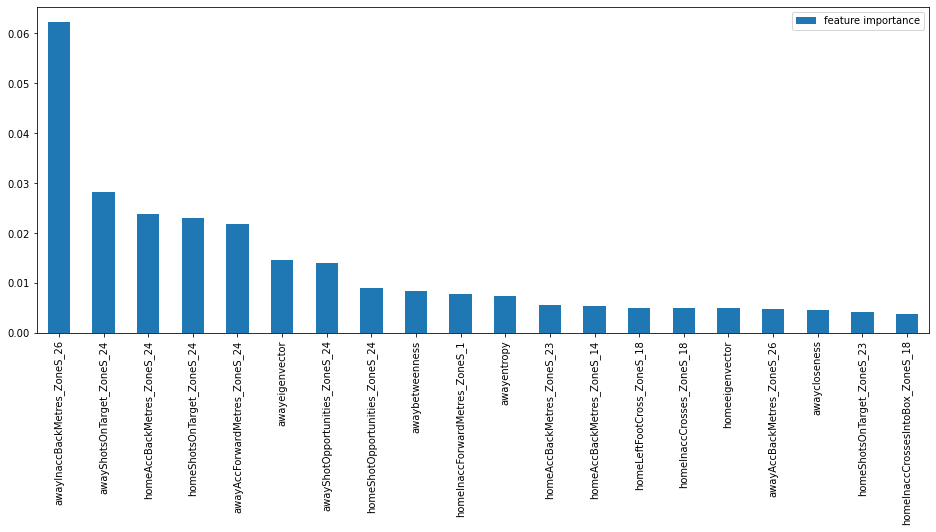

In [119]:
df_feature_importance[0:20].plot(kind='bar')



In [120]:
## DNN

In [121]:
# X_trainD, X_testD, y_trainD, y_testD = train_test_split(X_train, y_train, test_size=0.2)

In [122]:
# from sklearn.preprocessing import StandardScaler

In [123]:
# scaler = StandardScaler().fit(X_trainD)

# X_trainD = scaler.transform(X_trainD)

# X_testD = scaler.transform(X_testD)

# X_testD2 = scaler.transform(X_test)

In [124]:
# # Define per-fold score containers
# acc_per_fold = []
# loss_per_fold = []

# kfold = KFold(n_splits=5, shuffle=True)

# fold_no=1

# for train, test in kfold.split(X_trainD, y_trainD):
    
#     dnn = Sequential()
#     #dnn.add(Flatten(input_shape=(500,3)))
#     #dnn.add(Dense(512, activation='relu',kernel_initializer = 'he_normal'))
#     #dnn.add(Dropout(0.3))
#     dnn.add(Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(X_testD2.shape[1],)))
#     dnn.add(Dropout(0.4))
#     dnn.add(Dense(128, activation='relu',kernel_initializer = 'he_normal'))
#     dnn.add(Dropout(0.4))
#     dnn.add(Dense(64, activation='relu',kernel_initializer = 'he_normal'))
#     dnn.add(Dropout(0.4))
#     dnn.add(Dense(1, activation='sigmoid',kernel_initializer = 'he_normal'))
#     #optim = keras.optimizers.SGD(lr=0.01, momentum=0.975, decay=2e-06, nesterov=True)
#     opt = keras.optimizers.Adam(learning_rate=0.00000001)


#     dnn.compile(loss='categorical_crossentropy',
#     optimizer=opt, metrics=['accuracy'])


#     #history = model.fit(X_train2, y_train2,
#     #batch_size = 32, epochs = 1,  verbose = 2)#, validation_data= (x_valid, y_valid))

#     history = dnn.fit(X_trainD[train], y_trainD[train], validation_data = (X_trainD[test], y_trainD[test]), epochs=2500, batch_size=32, verbose =2)

#     # batchsize 256
#     #lr 0.00001, 0.0001

#     print(dnn.summary())

#     # Generate generalization metrics
#     scores = model.evaluate(X_trainD[test], y_trainD[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
#     # Increase fold number
#     fold_no = fold_no + 1

# # score = model.evaluate(X_test2, y_test2, verbose=0)
# # print('Test loss:', score[0])
# # print('Test top 1 accuracy:', score[1])

# # == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
#     print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')

In [125]:

# y_pred = dnn.predict(X_testD2)
# #Converting predictions to label
# pred = list()
# for i in range(len(y_pred)):
#     pred.append(np.argmax(y_pred[i]))
# # #Converting one hot encoded test label to label
# # test = list()
# # for i in range(len(y_test2)):
# #     test.append(np.argmax(y_test[i]))





In [126]:
# a = accuracy_score(pred,y_test)
# print('Accuracy is:', a*100)

## fdnn

In [127]:
X_test2 = [tree.predict(X_test) for tree in clf.estimators_]
X_test2 = np.transpose(X_test2)
X_train2 = [tree.predict(X_train) for tree in clf.estimators_]
X_train2 = np.transpose(X_train2)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: User

In [128]:
# x_total = [tree.predict(result) for tree in clf.estimators_]
# x_total = np.transpose(x_total)

In [129]:
def X_transform(X):
    df = []  
    for sample in X:
        s = []
        for feature in sample:
            if feature == 2:
                s.append([0, 0, 1])
            elif feature == 1:
                s.append([0, 1, 0])
            else:
                s.append([1, 0, 0])
        df.append(s)
    df = np.array(df)
    return df

In [130]:
X_train2 = X_transform(X_train2)
X_test2 = X_transform(X_test2)

In [131]:
X_train2.shape
X_test2.shape

(366, 500, 3)

In [132]:
## one-hot encode the labels
def y_transform(Y):
    df = []
    for l in Y:
        if l == 1:
            df.append([0, 0, 1])
        elif l == 0:
            df.append([0, 1, 0])
        else:
            df.append([1, 0, 0])
    df = np.array(df,dtype=int)
    return df

In [133]:
y_train2 = y_transform(y_train)
y_test2 = y_transform(y_test)

In [134]:
print(y_train2.shape)
print(y_test2.shape)

(1460, 3)
(366, 3)


In [135]:
# X_train2, X_test3, y_train2, y_test3 = train_test_split(X_train2, y_train2, test_size=0.2)


In [136]:
print(y_train2.shape)
print(X_train2.shape)


(1460, 3)
(1460, 500, 3)


##### Keras DNN

In [137]:
# Model

# # Define per-fold score containers
# acc_per_fold = []
# loss_per_fold = []

# kfold = KFold(n_splits=3, shuffle=True)

# fold_no=1

# for train, test in kfold.split(X_train2, y_train2):
def create_model(learning_rate=0.000001):
    model = Sequential()
    model.add(Flatten(input_shape=(500,3)))
    model.add(Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(500*3,)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax',kernel_initializer = 'he_normal'))
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


    
#     # Generate generalization metrics
#     scores = model.evaluate(X_train2[test], y_train2[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
#     # Increase fold number
#     fold_no = fold_no + 1

In [138]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [139]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [140]:
# # define the grid search parameters
# batch_size = [16, 32, 64, 128, 256]
# epochs = [1000, 2000, 2500,3000,3500,4000,5000]
# learning_rate=[0.0001, 0.00001, 0.000001,0.0000001,0.00000001]

# param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
# grid_result = grid.fit(X_train2, y_train2)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# # grid.result.predict(X_test2)

# # history = model.fit(X_train2[train], y_train2[train], validation_data = (X_train2[test], y_train2[test]), epochs=2000, batch_size=32, verbose =2)

# # print(model.summary())

In [141]:
model.fit(X_train2, y_train2, epochs=2000, batch_size=32, verbose =0)

2022-02-08 11:36:41.880669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [163]:
model.score(X_test2,y_test2)

0.6584699749946594

In [142]:
y_pred = model.predict(X_test2)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test2)):
    test.append(np.argmax(y_test2[i]))

In [143]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 30.05464480874317


In [144]:
# # == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
#     print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')

In [145]:
y_pred = model.predict(X_test2)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test2)):
    test.append(np.argmax(y_test2[i]))

In [146]:
for i in range(len(pred)):
    if pred[i]==2:
        pred[i] = 1
    elif pred[i]==0:
        pred[i]= -1
    else:
        pred[i]=0

In [147]:
for i in range(len(test)):
    if test[i]==2:
        test[i] = 1
    elif test[i]==0:
        test[i]= -1
    else:
        test[i]=0

Text(45.722222222222214, 0.5, 'Actual Result')

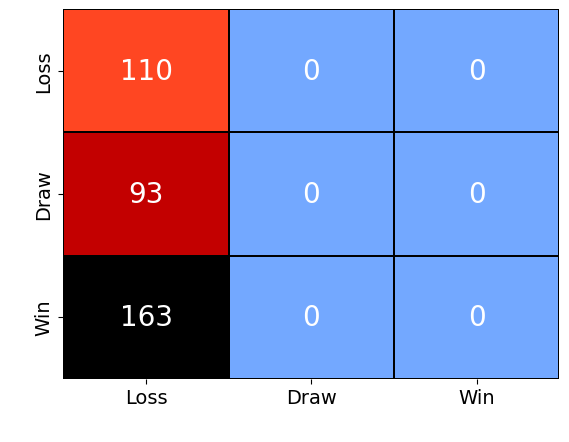

In [148]:
cf_matrix = confusion_matrix(y_test, pred)
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(1)
x_axis_labels,y_axis_labels = ["Loss", "Draw", "Win"], ["Loss", "Draw", "Win"]
#sns.color_palette("magma")
sns.heatmap(cf_matrix, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels, center=50, linecolor="black", cmap='flag', linewidths=0.2, annot_kws={'size':20},cbar=False), #,cmap="PiYG")
plt.xlabel("Predicted Result",  color = "white")
plt.ylabel("Actual Result",  color = "white")



In [149]:
labels = [-1,0,1]

print(classification_report(test, pred, labels = labels,target_names=['Loss', 'Draw', 'Win']))
print('accuracy score: {0:.4f}'.format(accuracy_score(test,pred)))

              precision    recall  f1-score   support

        Loss       0.30      1.00      0.46       110
        Draw       0.00      0.00      0.00        93
         Win       0.00      0.00      0.00       163

    accuracy                           0.30       366
   macro avg       0.10      0.33      0.15       366
weighted avg       0.09      0.30      0.14       366

accuracy score: 0.3005


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
print(pd.crosstab(np.array(test), np.array(pred), rownames=['Actual Result'], colnames=['Predicted Result']))
class_name = list(set(test))
print(class_name)

Predicted Result   -1
Actual Result        
-1                110
 0                 93
 1                163
[0, 1, -1]


In [140]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [141]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

NameError: name 'history' is not defined

###### XGBoost DNN

In [151]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [152]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.0001,0.001, 0.01, 0.02,0.1, 0.2, 0.3],
        'n_estimators': [100,200,500,1000]
        }

In [153]:
import datetime
from datetime import *

In [154]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [155]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [156]:
# param_comb = 5
# folds = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

# # xgb.fit(X_train, y_train)




In [157]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)

In [158]:
##### CREATE XGB WITH OPTIMIZED PARAMS
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.8}

xgb = XGBClassifier(features_names=X_all.columns, gamma=1.5, n_estimators =500, max_depth=7, min_child_weight=5)
xgb.fit(X_train, y_train)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "features_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              features_names=Index(['homeAccBackMetres_ZoneS_1', 'awayAccBackMetres_ZoneS_1',
       'homeAccBackMetres_ZoneS_2', 'awayAccBackMetres_ZoneS_2',
       'homeAccBackMetres_ZoneS_3', 'awayAccBackMetres_ZoneS_3',
       'homeAccBackMetres_ZoneS_4', 'aw...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [159]:
# feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')57.1
# plt.ylabel('Feature Importance Score')

In [160]:
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 67.21%


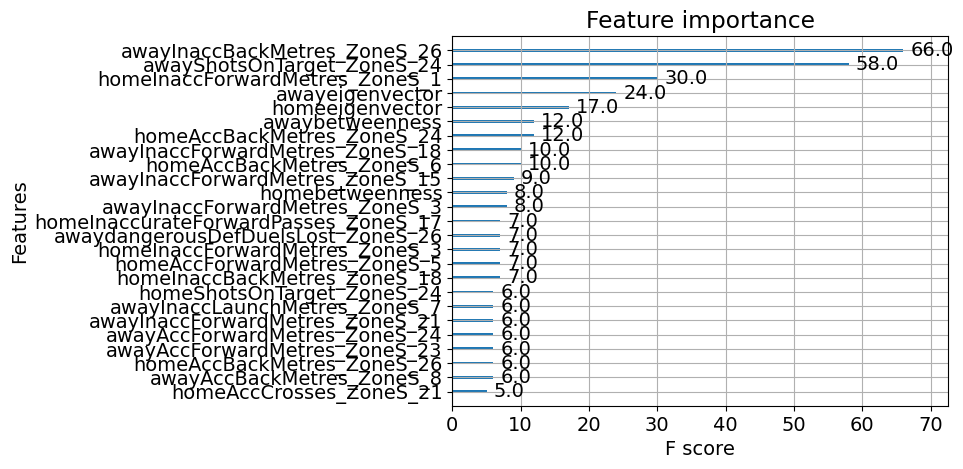

<Figure size 500x500 with 0 Axes>

In [161]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb, max_num_features=25, ylabel="Features")
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()

In [162]:
allDone()